In [74]:
import gymnasium as gym
import mujoco
from gymnasium.envs.mujoco.half_cheetah_v4 import HalfCheetahEnv
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from gymnasium.wrappers import TimeLimit
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor, load_results

PARAM_DIR = 'params'
rewards_history = []

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_reward = 0
        self.curr_ep = 0

    def _on_step(self) -> bool:
        # Accumulate rewards for the current episode
        if self.locals['iteration'] > self.curr_ep:
            # Store the total reward for the episode
            self.episode_rewards.append(self.episode_reward)
            self.episode_reward = 0
            self.curr_ep = self.locals['iteration']
            
        self.episode_reward += self.locals['rewards'][-1]
        return True

    def _on_training_end(self) -> None:
        global rewards_history
        rewards_history.append(self.episode_rewards)

def create_custom_env(env_class, render_mode=None, *args, **kwargs):
    """
    Creates a custom Frozen Lake environment.
    
    :param custom_map: List of strings representing the map.
    :param is_slippery: Boolean indicating whether the surface is slippery.
    :return: Custom Frozen Lake environment.
    """
    print(f"Creating custom environment -> {str(env_class)}")
    env = env_class(render_mode='rgb_array',*args, **kwargs)
    # if render_mode is not None:
    #     env.render(mode=render_mode)
    return env

def train_ppo_on_map(
    total_timesteps=10000, 
    pretrained_model_path=None, 
    rollout_steps=2048,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5, 
    render_mode=None, 
    env_class=HalfCheetahEnv, 
    *args, 
    **kwargs
    ):
    """
    Trains a PPO agent on a custom Frozen Lake map.
    
    :param custom_map: List of strings representing the map.
    :param total_timesteps: Total timesteps for training.
    :param is_slippery: Boolean indicating whether the surface is slippery.
    :return: Trained PPO model.
    """

    max_steps = 1000
    env = create_custom_env(env_class=env_class, render_mode=render_mode, *args, **kwargs)
    env = TimeLimit(env, max_episode_steps=max_steps)
    env = Monitor(env)
    env = make_vec_env(lambda: env, n_envs=1)  # Vectorize the environment

    # Initialize the PPO model
    if pretrained_model_path is not None:
        print("Loading pretrained model from path: ", pretrained_model_path)
        model = PPO.load(pretrained_model_path, env, n_steps=rollout_steps, device='cuda')
    else:
        model = PPO("MlpPolicy", env, verbose=1, n_steps=rollout_steps, device='cuda')

    # Train the model
    global reward_callback
    reward_callback = RewardCallback()
    model.learn(total_timesteps=total_timesteps, callback=reward_callback)

    env = env.get_attr('env')[0]
    return env, model



# Train the PPO agent on the baseline map
env, trained_model = train_ppo_on_map(
    total_timesteps=50_000, 
    rollout_steps=1000, 
    clip_range=0.3,
    ent_coef=0.01,
    vf_coef=0.5,
    env_class=HalfCheetahEnv)

# Save the model
# trained_model.save(f"{PARAM_DIR}/ppo_frozenlake_baseline")
# trained_model.save(f"{PARAM_DIR}/ppo_half_cheetah_baseline")


Creating custom environment -> <class 'gymnasium.envs.mujoco.half_cheetah_v4.HalfCheetahEnv'>
Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -309     |
| time/              |          |
|    fps             | 528      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1000     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -298        |
| time/                   |             |
|    fps                  | 397         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2000        |
| train/                  |             |
|    approx_kl            | 0.011288006 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
| 

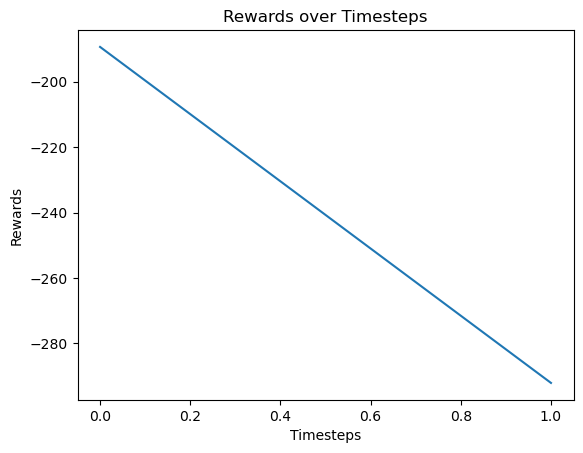

In [87]:
from typing import List
import matplotlib.pyplot as plt
def plotter(env=env, data=None):
    if data is not None:
        plt.plot(data)
    else:
        plt.plot(env.get_episode_rewards())
    plt.xlabel('Timesteps')
    plt.ylabel('Rewards')
    plt.title('Rewards over Timesteps')
    plt.show()

plotter()

In [ ]:
from modified_gym_envs.ModifiedHalfCheetah import ModifiedHalfCheetahEnv

env1, trained_model1 = train_ppo_on_map(total_timesteps=1000, env_class=ModifiedHalfCheetahEnv, render_mode='rgb_array')

In [76]:
import cv2
import IPython.display as display
import ipywidgets as widgets
import time


def render_game_to_cell(obs):
    if obs is None or obs.size == 0:
        print("Empty frame received")
        return
    screen_data = obs
    frame = cv2.cvtColor(screen_data, cv2.COLOR_RGB2BGR)
    _, jpeg = cv2.imencode('.jpeg', frame)
    image_widget.value = jpeg.tobytes()

image_widget = widgets.Image(format='jpeg')
display.display(image_widget)

Image(value=b'', format='jpeg')

In [ ]:
obs, _ = env.reset()
for i in range(1000):
    action, _states = trained_model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    render_game_to_cell(env.render())
    time.sleep(0.02)
    if dones:
        obs = env.reset()
        time.sleep(1)

In [79]:
from modified_gym_envs.ModifiedHalfCheetah import ModifiedHalfCheetahEnv

# env, trained_model = train_ppo_on_map(total_timesteps=50000, env_class=ModifiedHalfCheetahEnv, render_mode='rgb_array')

In [80]:
from modified_gym_envs.ModifiedHalfCheetah import ModifiedHalfCheetahEnv

env = ModifiedHalfCheetahEnv(render_mode='rgb_array')

## Alternating Environment Experiment

### OG Half Cheetah

In [6]:
env, trained_model = train_ppo_on_map(total_timesteps=500000, env_class=HalfCheetahEnv, render_mode='rgb_array')

Creating custom environment -> <class 'gymnasium.envs.mujoco.half_cheetah_v4.HalfCheetahEnv'>
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 598  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 484         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010083568 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.49       |
|    explained_variance   | -0.0748     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.63        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0205     |
|    s

### OG Half Cheetah Viz

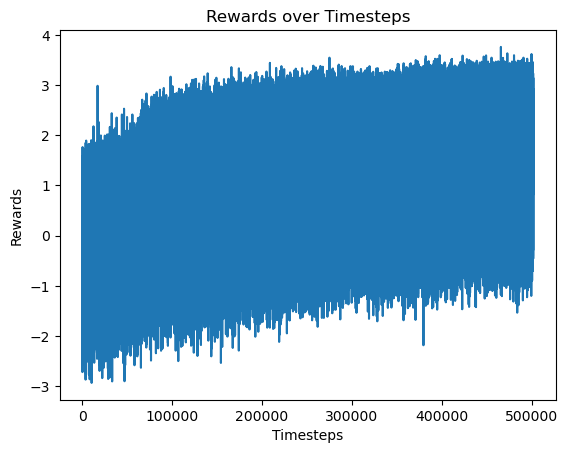

In [8]:
plotter()

In [14]:
import cv2
import IPython.display as display
import ipywidgets as widgets
import time

def render_here():
    image_widget = widgets.Image(format='jpeg')
    display.display(image_widget)
    return image_widget

def render_game_to_cell(obs, image_widget):
    if obs is None or obs.size == 0:
        print("Empty frame received")
        return
    screen_data = obs
    frame = cv2.cvtColor(screen_data, cv2.COLOR_RGB2BGR)
    _, jpeg = cv2.imencode('.jpeg', frame)
    image_widget.value = jpeg.tobytes()

In [33]:
image_widget = render_here()

obs = env.reset()
for i in range(1000):
    action, _states = trained_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    render_game_to_cell(env.render(mode='rgb_array'), image_widget)
    time.sleep(0.05)
    if dones:
        obs = env.reset()
        time.sleep(1)

Image(value=b'', format='jpeg')

KeyboardInterrupt: 

In [16]:
trained_model.save(f"{PARAM_DIR}/ppo_modified_half_cheetah_baseline")

### Modified Half Cheetah

In [20]:
# refresh import modified half cheetah file
import importlib
from modified_gym_envs import ModifiedHalfCheetah

importlib.reload(ModifiedHalfCheetah)

<module 'modified_gym_envs.ModifiedHalfCheetah' from 'c:\\Users\\patel\\OneDrive - iiit-b\\Desktop\\coursework\\sem 7\\Topics in AI\\code\\modified_gym_envs\\ModifiedHalfCheetah.py'>

In [22]:
from modified_gym_envs.ModifiedHalfCheetah import ModifiedHalfCheetahEnv

env1, trained_model1 = train_ppo_on_map(
    total_timesteps=500000, 
    env_class=ModifiedHalfCheetahEnv, 
    pretrained_model_path=f"{PARAM_DIR}/ppo_modified_half_cheetah_baseline", 
    render_mode='rgb_array'
    )

Creating custom environment -> <class 'modified_gym_envs.ModifiedHalfCheetah.ModifiedHalfCheetahEnv'>
-----------------------------
| time/              |      |
|    fps             | 620  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 472         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.053700753 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.4         |
|    explained_variance   | -0.935      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.36        |
|    n_updates            | 2460        |
|    policy_gradient_loss | -0.0315     |
|    std        

### Modified Half Cheetah Viz

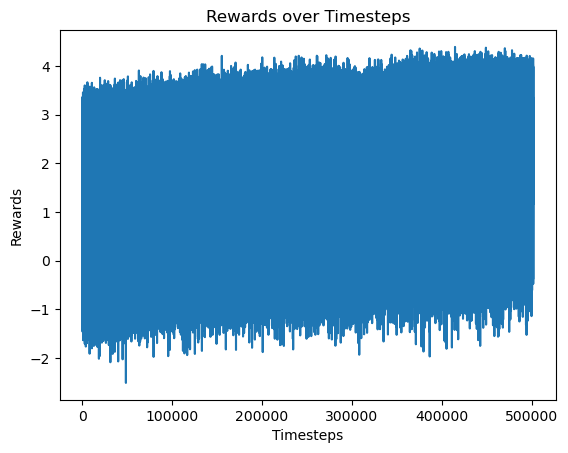

In [23]:
plotter()

In [34]:
image_widget = render_here()

obs = env1.reset()
for i in range(1000):
    action, _states = trained_model1.predict(obs)
    obs, rewards, dones, info = env1.step(action)
    render_game_to_cell(env1.render(mode='rgb_array'), image_widget)
    time.sleep(0.05)
    if dones:
        obs = env1.reset()
        time.sleep(1)

Image(value=b'', format='jpeg')

KeyboardInterrupt: 

In [27]:
trained_model1.save(f"{PARAM_DIR}/ppo_modified_half_cheetah_first")

### Ant Env

In [25]:
# get Ant env
from gymnasium.envs.mujoco.ant_v4 import AntEnv

ant_env, ant_trained_model = train_ppo_on_map(
    total_timesteps=50000, 
    env_class=AntEnv, 
    render_mode='rgb_array'
    )

Creating custom environment -> <class 'gymnasium.envs.mujoco.ant_v4.AntEnv'>
Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.7     |
|    ep_rew_mean     | -34.7    |
| time/              |          |
|    fps             | 438      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.7        |
|    ep_rew_mean          | -34.7       |
| time/                   |             |
|    fps                  | 355         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012381075 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss  

In [35]:
image_widget = render_here()

obs = ant_env.reset()
for i in range(1000):
    action, _states = ant_trained_model.predict(obs)
    obs, rewards, dones, info = ant_env.step(action)
    render_game_to_cell(ant_env.render(mode='rgb_array'), image_widget)
    time.sleep(0.05)
    if dones:
        obs = ant_env.reset()
        time.sleep(1)

Image(value=b'', format='jpeg')

### Back to OG Half Cheetah Again

In [28]:
env, trained_model2 = train_ppo_on_map(
    total_timesteps=100000, 
    env_class=HalfCheetahEnv, 
    pretrained_model_path=f"{PARAM_DIR}/ppo_modified_half_cheetah_first",
    render_mode='rgb_array'
    )

Creating custom environment -> <class 'gymnasium.envs.mujoco.half_cheetah_v4.HalfCheetahEnv'>
-----------------------------
| time/              |      |
|    fps             | 586  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 455        |
|    iterations           | 2          |
|    time_elapsed         | 8          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.06391615 |
|    clip_fraction        | 0.43       |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.97       |
|    explained_variance   | 0.233      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.02       |
|    n_updates            | 4910       |
|    policy_gradient_loss | -0.0168    |
|    std                  | 0.126      |

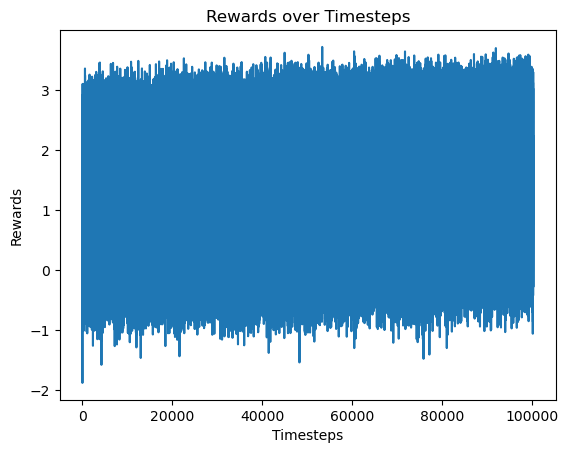

In [29]:
plotter()

In [31]:
image_widget = render_here()

obs = env.reset()
for i in range(1000):
    action, _states = trained_model2.predict(obs)
    obs, rewards, dones, info = env.step(action)
    render_game_to_cell(env.render(mode='rgb_array'), image_widget)
    time.sleep(0.05)
    if dones:
        obs = env.reset()
        time.sleep(1)

Image(value=b'', format='jpeg')

KeyboardInterrupt: 

### Mujoco Alternating Tasks 

In [93]:
EXP = [HalfCheetahEnv, ModifiedHalfCheetahEnv]
episodic_rewards = []
time_steps = 400_000
for i in range(10):
    if i == 0:
        env, trained_model = train_ppo_on_map(
            total_timesteps=time_steps, 
            env_class=EXP[i%2], 
            rollout_steps=1000,
            render_mode='rgb_array'
            )
        trained_model.save(f"{PARAM_DIR}/ppo_alternating_half_cheetah")
        episodic_rewards.extend(env.get_episode_rewards())
    else:
        env, trained_model = train_ppo_on_map(
            total_timesteps=time_steps, 
            env_class=EXP[i%2], 
            rollout_steps=1000,
            pretrained_model_path=f"{PARAM_DIR}/ppo_alternating_half_cheetah",
            render_mode='rgb_array'
            )
        trained_model.save(f"{PARAM_DIR}/ppo_alternating_half_cheetah")
        episodic_rewards.extend(env.get_episode_rewards())
    print(f"Completed training on {EXP[i%2]}")

Creating custom environment -> <class 'gymnasium.envs.mujoco.half_cheetah_v4.HalfCheetahEnv'>
Using cuda device


c:\Users\patel\anaconda3\envs\tiai\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1000`, after every 15 untruncated mini-batches, there will be a truncated mini-batch of size 40
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1000 and n_envs=1)
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -379     |
| time/              |          |
|    fps             | 614      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1000     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -366        |
| time/                   |             |
|    fps                  | 484         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2000        |
| train/                  |             |
|    approx_kl            | 0.011697362 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.49       |
|    explained_variance   | -0.0416     |
|    learning_rate        | 0.

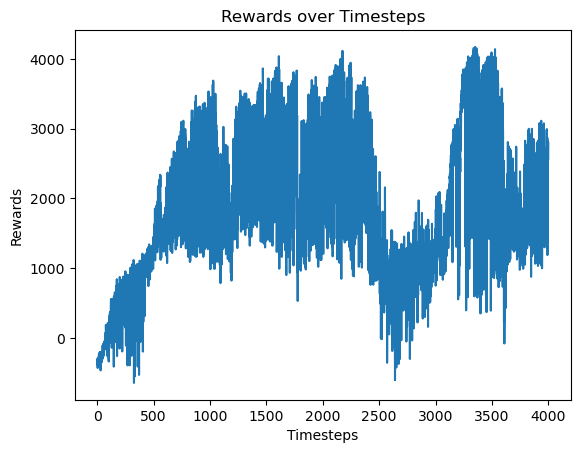

In [94]:
plotter(data=episodic_rewards)

In [96]:
data = episodic_rewards.copy()

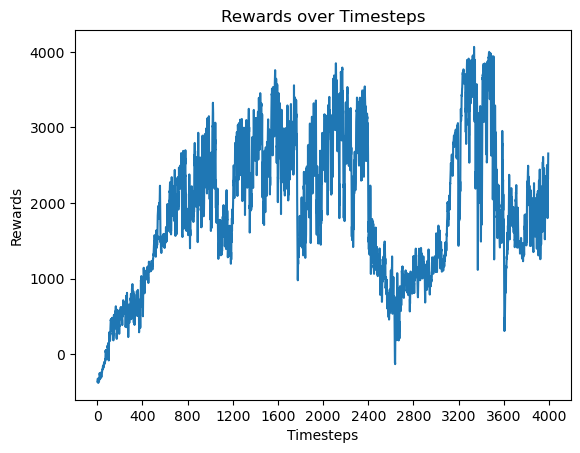

In [112]:
# smoothen the rewards curve
def smoothen(data, window=5):
    return [sum(data[i:i+window])/window for i in range(len(data)-window)]

# plotter(data=smoothen(data, window=5))
smooth_data = smoothen(data, window=5)
# divide the axis in 10 parts
n = 10
plt.plot(smooth_data)
plt.xticks(range(0, len(smooth_data) + 10, 400), range(0, len(smooth_data) + 10, 400))
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Rewards over Timesteps')
plt.show()


### Test on OG Half Cheetah

In [ ]:
trained_model.save(f"{PARAM_DIR}/ppo_alternating_half_cheetah")

In [120]:
image_widget = widgets.Image(format='jpeg')
display.display(image_widget)
env_test = HalfCheetahEnv(render_mode='rgb_array')

obs, _ = env_test.reset()
for i in range(1000):
    action, _states = trained_model.predict(obs)
    obs, rewards, dones, _, info = env_test.step(action)
    render_game_to_cell(env_test.render())
    time.sleep(0.05)
    if dones:
        obs = env_test.reset()
        time.sleep(1)

Image(value=b'', format='jpeg')

KeyboardInterrupt: 

In [121]:
image_widget = widgets.Image(format='jpeg')
display.display(image_widget)
env_test = ModifiedHalfCheetahEnv(render_mode='rgb_array')

obs, _ = env_test.reset()
for i in range(1000):
    action, _states = trained_model.predict(obs)
    obs, rewards, dones, _, info = env_test.step(action)
    render_game_to_cell(env_test.render())
    time.sleep(0.05)
    if dones:
        obs = env_test.reset()
        time.sleep(1)

Image(value=b'', format='jpeg')

KeyboardInterrupt: 